In [2]:
import time
from pynput import mouse # type: ignore
from pynput.mouse import Button, Controller # type: ignore
from PIL import ImageGrab
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import sys
import matplotlib.pyplot as plt
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
import cv2


In [58]:
def chargerImage(image_url):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    return image


def draw_line(tupleCoordonnees, initialCoordonate):
    mouse = Controller()
    x1 = tupleCoordonnees[0][0] + initialCoordonate[0]
    x2 = tupleCoordonnees[1][0] + initialCoordonate[0]

    y1 = tupleCoordonnees[0][1] + initialCoordonate[1]
    y2 = tupleCoordonnees[1][1] + initialCoordonate[1]

    mouse.position = (x1, y1)
    time.sleep(0.008)
    mouse.press(Button.left)
    mouse.position = (x2, y2)
    time.sleep(0.008)
    mouse.release(Button.left)

def dessiner(initalCoordonate, listeDessin,positionCouleur ):
    mouse = Controller()
    mouse.position = positionCouleur
    time.sleep(0.01)
    mouse.click(Button.left, 1)
    time.sleep(0.01)

    for trait in listeDessin:
        draw_line(trait, initalCoordonate)
    return


def recupererCouleurPixel(x,y,couleurs):
    img = ImageGrab.grab(bbox=(int(x), int(y), int(x + 1), int(y +1)))
    couleurs.append(np.array(img.getpixel((0, 0)))[:3])

def couleurPlusProche(colorColor, pixel):
    distancePlusPetite = 10000
    couleurRemplacement = (0,0,0)

    for color in colorColor:
        if np.all(pixel == color):
            return color
        else:
            distance = np.linalg.norm(np.array(pixel) - np.array(color))
            if distance < distancePlusPetite:
                couleurRemplacement = color
                distancePlusPetite = distance

    return couleurRemplacement

def changerCouleur(colorColor, pixels):
    colorColor = np.array(colorColor)
    shape = pixels.shape
    pixels_flat = pixels.reshape(-1, pixels.shape[-1])

    for i in range(pixels_flat.shape[0]):
        pixel = pixels_flat[i][:3]
        pixels_flat[i][:3] = couleurPlusProche(colorColor, pixel)

    return pixels.reshape(shape)

def recurerPaletteCouleurs(positionsCouleurs, nbCouleurs, couleurs):
    nbCouleurs = int(nbCouleurs)
    def getColor(x, y, button, pressed):
        nonlocal nbCouleurs
        if pressed and len(positionsCouleurs) < nbCouleurs:
            recupererCouleurPixel(x, y, couleurs)
            positionsCouleurs.append((int(x), int(y)))
            if len(positionsCouleurs) == nbCouleurs:
                print("Fin de la selection de la palette de couleurs.")
                return False
    
    with mouse.Listener(on_click=getColor) as listener:
        listener.join()
    print("Fin de la selection de la palette de couleurs.")


def recupererCoinsGrille(positionsCoins):
    def getGrid(x, y, button, pressed):
        if pressed and len(positionsCoins) < 2:
            positionsCoins.append((int(x), int(y)))
            if len(positionsCoins) == 2:
                return False  # Stop listener when enough points are selected

    with mouse.Listener(on_click=getGrid) as listener:
        listener.join()
    print("Fin de la selection de la grille.")
    print("Positions grille:", positionsCoins)



def calculerDimensionsGrille(positionsCoins):
    largeur = abs(positionsCoins[0][0] - positionsCoins[1][0])
    hauteur = abs(positionsCoins[0][1] - positionsCoins[1][1])
    return largeur, hauteur


def generateMatricesCouleurs(couleurs, pixels, matriceExistance):
    matricesCouleurs = []
    for couleur in couleurs:
        if(np.all(couleur != [255,255,255])):
            matrice = np.zeros((pixels.shape[0], pixels.shape[1]))
            for i in range (len(pixels)):
                for j in range(pixels.shape[1]):
                    if np.any(pixels[i][j] == couleur) and matriceExistance[i][j] == 0:
                        matrice[i][j] = 1
                        matriceExistance[i][j] = 1
            matricesCouleurs.append(matrice)
    return matricesCouleurs


def ajouterColonnes0(matrices):
    colonne_zero = np.zeros((matrices[0].shape[0], 1))
    for i in range (len(matrices)):
        matrices[i] = np.hstack((matrices[i], colonne_zero))
        matrices[i] = np.hstack((colonne_zero,matrices[i]))
    return matrices


def epurerMatricesCouleurs(matrices):
    for matrice in matrices:
        for i in range(matrice.shape[0]):
            for j in range(matrice.shape[1]):
                if matrice[i][j] == 1:
                    if i > 0 and j > 0 and i < matrice.shape[0]-1 and j < matrice.shape[1]-1:
                        if ((matrice[i-1][j] == 0 and matrice[i+1][j] == 0) or (matrice[i][j-1] == 0 and matrice[i][j+1] == 0)):
                            matrice[i][j] = 0
    return matrices



def calculGradientMatrices(matrices):
    matricesGradient = []
    for matrice in matrices : 
        gradient = np.zeros_like(matrice)
        for i in range (0, matrice.shape[1]-1):
            gradient[:,i] = np.abs(matrice[:,i+1] - matrice[:,i])
        matricesGradient.append(gradient)
    return matricesGradient


def calculListesDessin(matricesGradient):
    listesDessin = []
    for matrice in matricesGradient:
        listeDessin = []
        for i in range(len(matrice)):
            line = []
            for j in range(len(matrice[0])):
                if matrice[i][j] == 1 and len(line) == 0:
                    line.append([j,i])
                elif matrice[i][j] == 1 and len(line) == 1:
                    line.append([j,i])
                    listeDessin.append((line[0],line[1]))
                    line = []
        listesDessin.append(listeDessin)
    return listesDessin

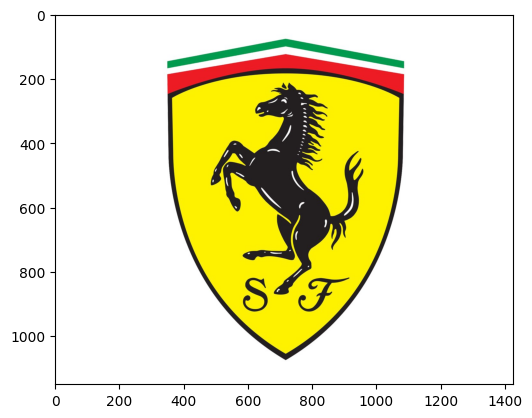

In [59]:
url = input("Entrez l'URL de l'image: ")
image = chargerImage(url)
image.load()
image2 = Image.new('RGB', image.size, (255, 255, 255))
image2.paste(image, None)
plt.imshow(image2)

Veuillez cliquer sur les 5 couleurs de la palette.
Fin de la selection de la palette de couleurs.
Fin de la selection de la palette de couleurs.
Positions couleurs: [(393, 479), (400, 436), (434, 575), (399, 568), (398, 659)]
Couleurs: [array([255, 255, 255]), array([0, 0, 0]), array([234,  51,  42]), array([ 81, 173,  76]), array([246, 195,  77])]
Veuillez cliquer sur les deux coins opposés de la grille.
Fin de la selection de la grille.
Positions grille: [(553, 373), (1292, 809)]
Dimensions grille: 739 436
Modification de la taille de l'image ... 
Calcul des nouvelles couleurs ...
Generation des matrices de couleurs ...


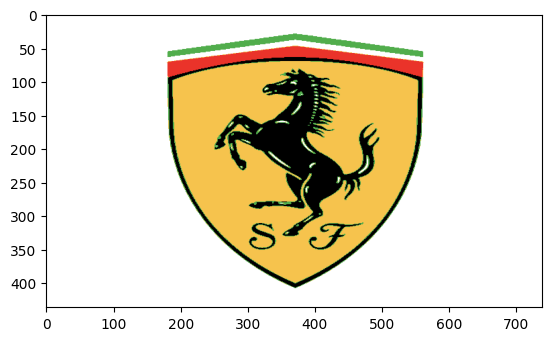

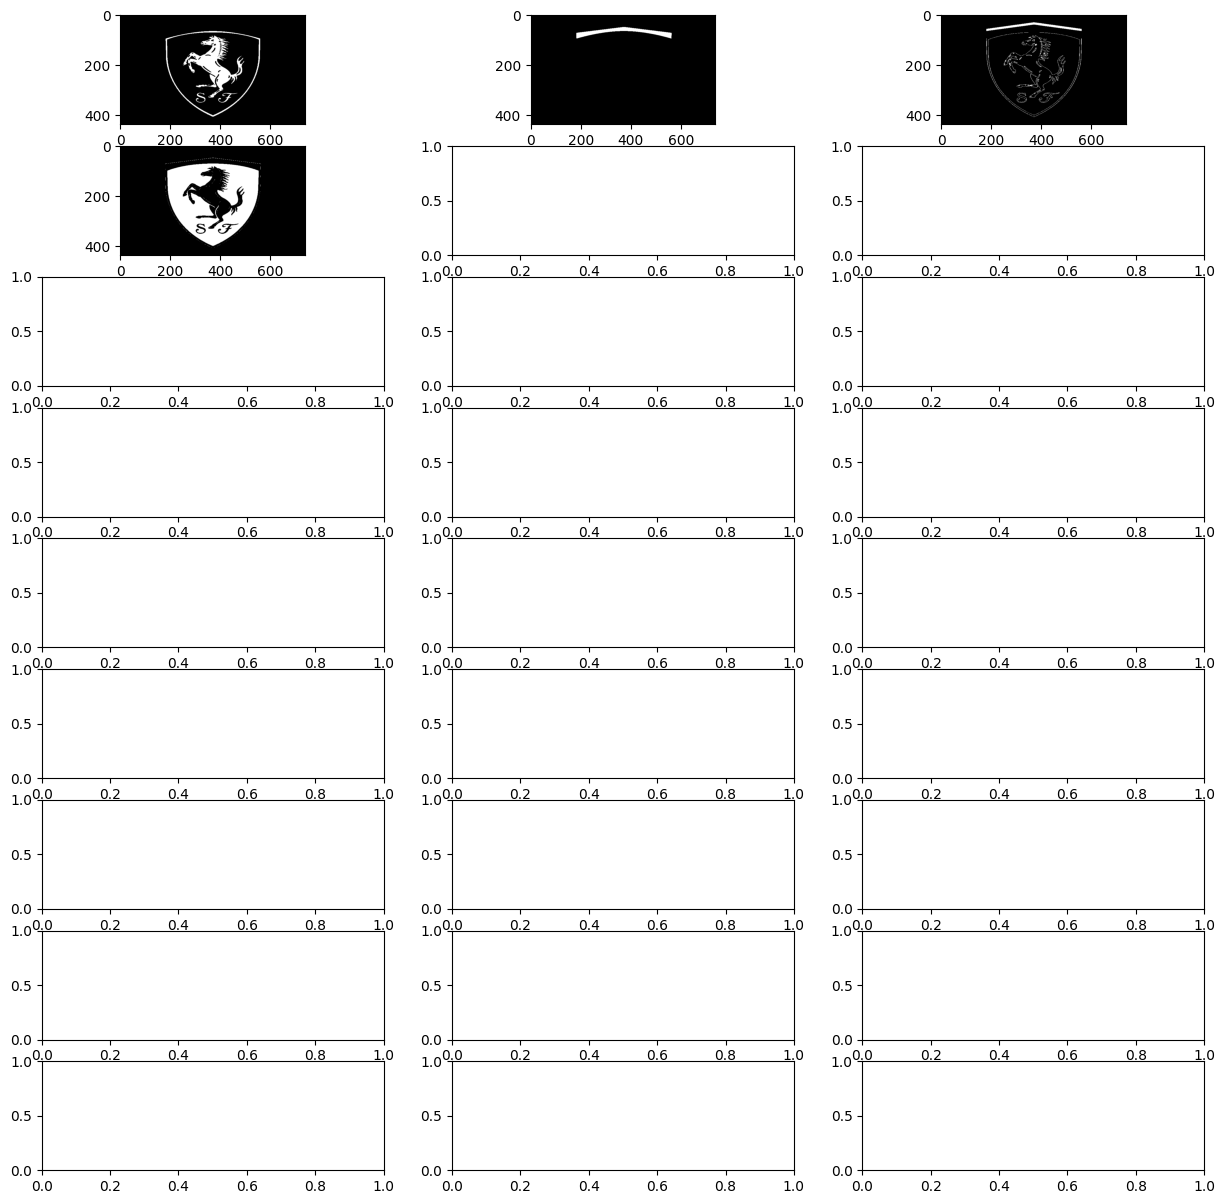

In [68]:
nbCouleurs = 5
positionsCouleurs = []
couleurs = []
print("Veuillez cliquer sur les {nbCouleurs} couleurs de la palette.".format(nbCouleurs=nbCouleurs))
recurerPaletteCouleurs(positionsCouleurs, nbCouleurs, couleurs)
print("Positions couleurs:", positionsCouleurs)
print("Couleurs:", couleurs)


positionsCoins = []
print("Veuillez cliquer sur les deux coins opposés de la grille.")
recupererCoinsGrille(positionsCoins)


largeur, hauteur = calculerDimensionsGrille(positionsCoins)
print("Dimensions grille:", largeur, hauteur)


print("Modification de la taille de l'image ... ")
image2 = image2.resize((largeur, hauteur))
pixels = np.array(image2)

print("Calcul des nouvelles couleurs ...")
pixels = changerCouleur(couleurs, pixels)
plt.imshow(pixels)

print("Generation des matrices de couleurs ...")
matriceExistance = np.zeros((pixels.shape[0], pixels.shape[1]))
matrices = generateMatricesCouleurs(couleurs, pixels, matriceExistance)
fig, axes = plt.subplots(9, 3, figsize=(15, 15))
axes = axes.flatten()
for i in range(len(matrices)):
    axes[i].imshow(matrices[i].astype(int),cmap='grey')





Epuration des matrices de couleurs ...


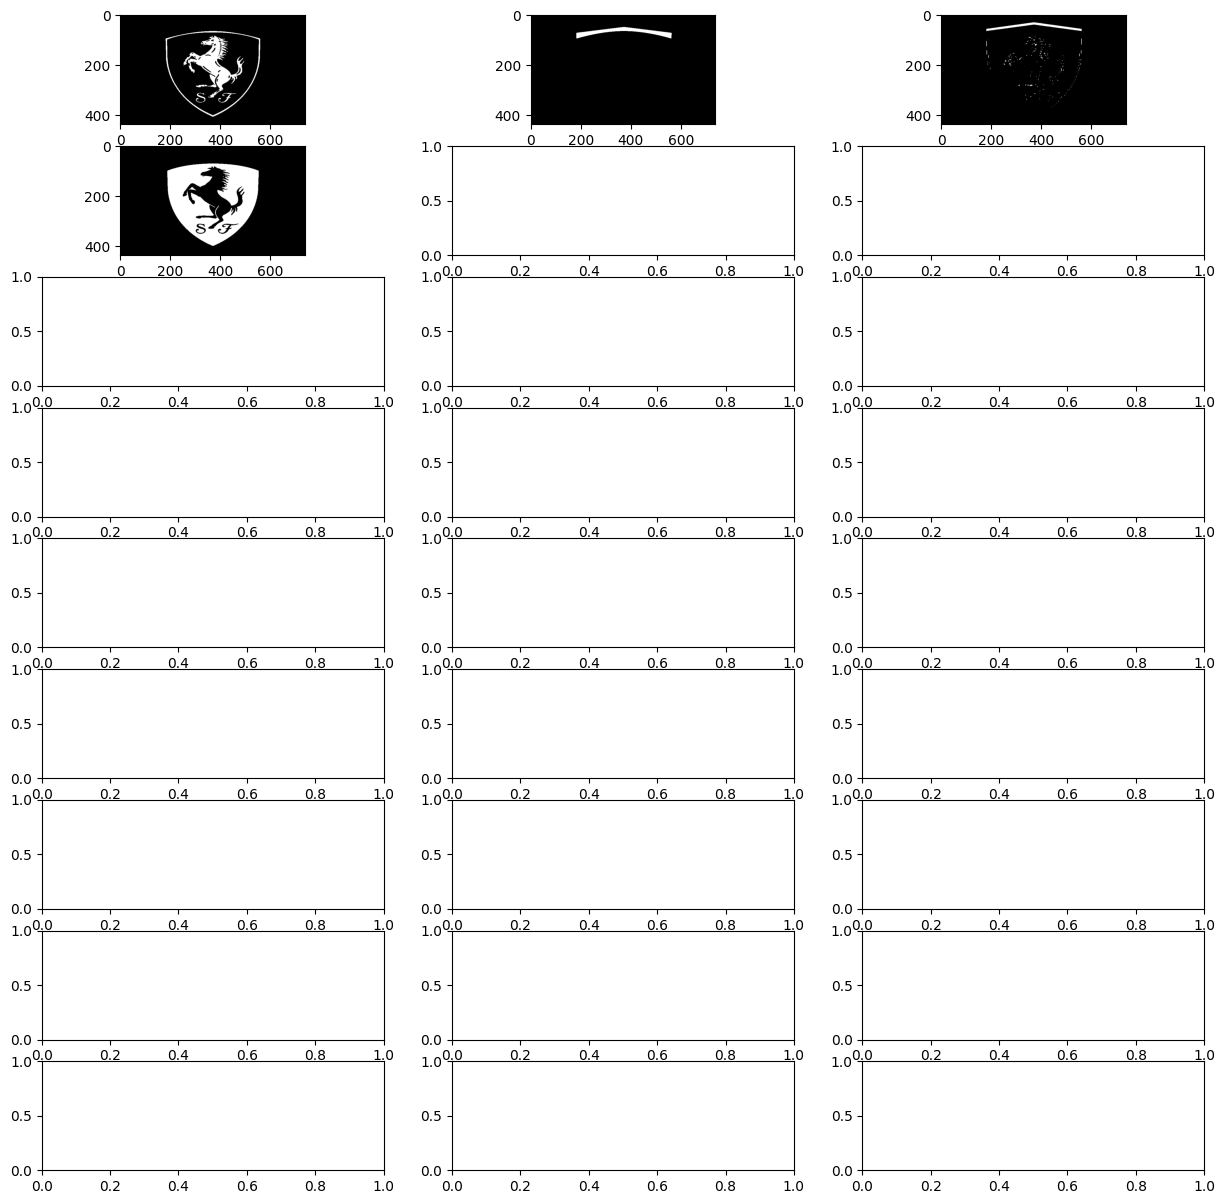

In [69]:
print("Epuration des matrices de couleurs ...")
matrices = epurerMatricesCouleurs(matrices)
fig, axes = plt.subplots(9, 3, figsize=(15, 15))
axes = axes.flatten()
for i in range(len(matrices)):
    axes[i].imshow(matrices[i].astype(int),cmap='grey')
    

Calcul des gradients ...


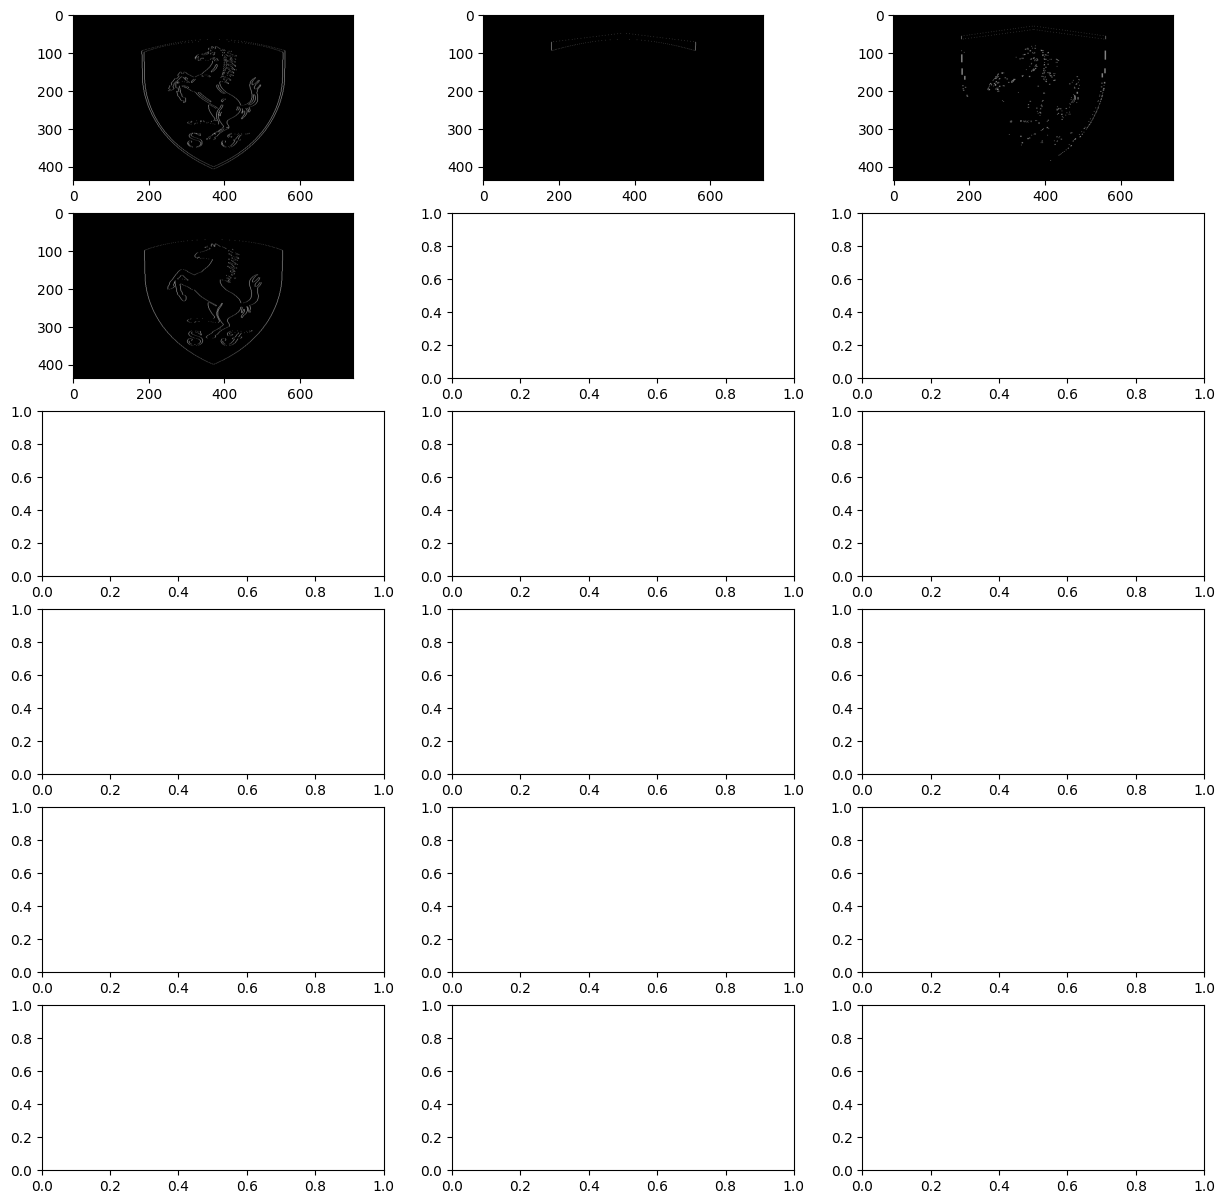

In [70]:
print("Calcul des gradients ...")
matricesGradient = calculGradientMatrices(matrices)
fig, axes = plt.subplots(6, 3, figsize=(15, 15))
axes = axes.flatten()
for i in range(len(matricesGradient)):
    axes[i].imshow(matricesGradient[i].astype(int), cmap='gray')

In [71]:
print("Calcul des matrices de dessin ...")
listesDessin = calculListesDessin(matricesGradient)
for i in range(len(listesDessin) - 1, -1, -1):
    print(listesDessin[i])

    # Vérifie si la longueur de la liste de dessin est inférieure à 30
    if len(listesDessin[i]) < 1:
        # Supprime les couleurs qui ne sont pas assez présentes
        listesDessin[i] = []
        # Affiche un message pour indiquer qu'une couleur a été supprimée
        print("Couleur supprimée")
        

Calcul des matrices de dessin ...
[([348, 70], [393, 70]), ([327, 71], [413, 71]), ([314, 72], [427, 72]), ([302, 73], [439, 73]), ([292, 74], [448, 74]), ([285, 75], [456, 75]), ([277, 76], [464, 76]), ([270, 77], [471, 77]), ([264, 78], [477, 78]), ([259, 79], [482, 79]), ([253, 80], [488, 80]), ([248, 81], [366, 81]), ([367, 81], [375, 81]), ([377, 81], [493, 81]), ([243, 82], [365, 82]), ([368, 82], [375, 82]), ([379, 82], [498, 82]), ([239, 83], [365, 83]), ([369, 83], [374, 83]), ([380, 83], [502, 83]), ([234, 84], [364, 84]), ([370, 84], [374, 84]), ([382, 84], [507, 84]), ([230, 85], [364, 85]), ([371, 85], [374, 85]), ([384, 85], [511, 85]), ([226, 86], [365, 86]), ([372, 86], [374, 86]), ([385, 86], [515, 86]), ([223, 87], [354, 87]), ([364, 87], [365, 87]), ([372, 87], [374, 87]), ([386, 87], [518, 87]), ([219, 88], [353, 88]), ([372, 88], [374, 88]), ([388, 88], [522, 88]), ([215, 89], [350, 89]), ([394, 89], [526, 89]), ([212, 90], [348, 90]), ([397, 90], [529, 90]), ([208

In [72]:
for i in range(len(couleurs) - 1, -1, -1):
            if np.all(couleurs[i] == [255,255,255]):
                couleurs.pop(i)
                positionsCouleurs.pop(i)

In [73]:
time.sleep(5)
for i in range(0,len(listesDessin)):
    dessiner(positionsCoins[0], listesDessin[i], positionsCouleurs[i])